# MDP Case Study - Flour Mill
Group E

This notebook solves the flour mill maintenance problem using Markov Decision Processes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

## Problem Data

The machine has 6 states: (Quality, Efficiency)
- States 1-3: High quality (Q0) with high/medium/low efficiency
- States 4-6: Low quality (Q1) with high/medium/low efficiency

In [2]:
# Base transition matrix
P_base = np.array([
    [0.60, 0.25, 0.05, 0.05, 0.03, 0.02],
    [0.20, 0.50, 0.20, 0.03, 0.05, 0.02],
    [0.10, 0.30, 0.40, 0.05, 0.10, 0.05],
    [0.15, 0.10, 0.05, 0.45, 0.20, 0.05],
    [0.05, 0.10, 0.15, 0.15, 0.45, 0.10],
    [0.02, 0.05, 0.10, 0.08, 0.15, 0.60]
])

print(pd.DataFrame(P_base, index=range(1,7), columns=range(1,7)))

      1     2     3     4     5     6
1  0.60  0.25  0.05  0.05  0.03  0.02
2  0.20  0.50  0.20  0.03  0.05  0.02
3  0.10  0.30  0.40  0.05  0.10  0.05
4  0.15  0.10  0.05  0.45  0.20  0.05
5  0.05  0.10  0.15  0.15  0.45  0.10
6  0.02  0.05  0.10  0.08  0.15  0.60


## Exercise 1: Decision Costs

Actions: N (no action), C (calibration), M (maintenance), R (replacement)

In [12]:
# Costs for each state and action
cost_matrix = {
    1: {'N': 0},
    2: {'N': 20, 'M': 40},
    3: {'N': 40, 'M': 60},
    4: {'N': 20, 'C': 50},
    5: {'N': 110, 'C': 70, 'M': 100},
    6: {'C': 80, 'M': 120, 'R': 2000}
}

# Show as table
cost_df = pd.DataFrame(index=range(1,7), columns=['N', 'C', 'M', 'R'])
for state in range(1, 7):
    for action in ['N', 'C', 'M', 'R']:
        cost_df.loc[state, action] = cost_matrix[state].get(action, '')

print("Cost Table:")
print(cost_df)

Cost Table:
     N   C    M     R
1    0               
2   20       40      
3   40       60      
4   20  50           
5  110  70  100      
6       80  120  2000


## Exercise 2: Policy Evaluation Functions

In [4]:
def apply_action(state, action):
    """Returns transition probabilities after applying an action"""
    transition = np.zeros(6)
    
    if action == 'N':
        # No action: use base transition
        transition = P_base[state - 1].copy()
    
    elif action == 'C':
        # Calibration: improve quality (Q1 -> Q0)
        if state == 4:
            transition[0] = 1.0  # Go to state 1
        elif state == 5:
            transition[1] = 1.0  # Go to state 2
        elif state == 6:
            transition[2] = 1.0  # Go to state 3
    
    elif action == 'M':
        # Maintenance: improve efficiency
        if state == 2:
            transition[0] = 1.0  # E2 -> E1
        elif state == 3:
            transition[1] = 1.0  # E3 -> E2
        elif state == 5:
            transition[3] = 1.0  # E2 -> E1
        elif state == 6:
            transition[4] = 1.0  # E3 -> E2
    
    elif action == 'R':
        # Replacement: new machine
        transition[0] = 1.0
    
    return transition


def build_transition_matrix(policy):
    """Exercise 2a: Build P(D) for a given policy"""
    P_D = np.zeros((6, 6))
    for state in range(1, 7):
        action = policy[state - 1]
        P_D[state - 1] = apply_action(state, action)
    return P_D


def compute_stationary_distribution(P_D):
    """Exercise 2b: Compute π(D) by solving π = π * P"""
    pi = np.ones(6) / 6
    for _ in range(10000):
        pi_new = pi @ P_D
        if np.linalg.norm(pi_new - pi) < 1e-10:
            break
        pi = pi_new
    return pi / pi.sum()


def compute_expected_cost(policy, pi):
    """Exercise 2c: Compute E(C(D)) = sum of πi * Ci(di)"""
    total = 0
    for state in range(1, 7):
        action = policy[state - 1]
        total += pi[state - 1] * cost_matrix[state][action]
    return total


def evaluate_policy(policy):
    """Exercise 4: Evaluate any policy"""
    P_D = build_transition_matrix(policy)
    pi = compute_stationary_distribution(P_D)
    cost = compute_expected_cost(policy, pi)
    return P_D, pi, cost


print("Functions defined.")

Functions defined.


### Test with an example policy

In [ ]:
# Test policy
test_policy = ['N', 'N', 'M', 'C', 'C', 'M']
P_D, pi, cost = evaluate_policy(test_policy)

print(f"Policy: {test_policy}\n")
print("P(D):")
print(pd.DataFrame(P_D, index=range(1,7), columns=range(1,7)))
print(f"\npi(D): {pi}")
print(f"\nExpected cost: {cost:.4f}")

Policy: ['N', 'N', 'M', 'C', 'C', 'M']

P(D):
     1     2     3     4     5     6
1  0.6  0.25  0.05  0.05  0.03  0.02
2  0.2  0.50  0.20  0.03  0.05  0.02
3  0.0  1.00  0.00  0.00  0.00  0.00
4  1.0  0.00  0.00  0.00  0.00  0.00
5  0.0  1.00  0.00  0.00  0.00  0.00
6  0.0  0.00  0.00  0.00  1.00  0.00

π(D): [0.31459445 0.47873068 0.11147586 0.03009164 0.04924087 0.0158665 ]

Expected cost: 23.1186


## Exercise 3: Find Optimal Policy

We enumerate all possible policies and find the best one.

In [6]:
# Available actions per state
actions = {
    1: ['N'],
    2: ['N', 'M'],
    3: ['N', 'M'],
    4: ['N', 'C'],
    5: ['N', 'C', 'M'],
    6: ['C', 'M', 'R']
}

# Generate all combinations
all_policies = list(product(actions[1], actions[2], actions[3], 
                            actions[4], actions[5], actions[6]))

print(f"Total policies: {len(all_policies)}")

Total policies: 72


In [ ]:
# Evaluate all policies
results = []
for policy in all_policies:
    _, _, cost = evaluate_policy(policy)
    results.append({'Policy': policy, 'Cost': cost})

results_df = pd.DataFrame(results).sort_values('Cost')

print("Best 5 policies:")
print(results_df.head(5))

print("\nWorst 5 policies:")
print(results_df.tail(5))

Best 10 policies:
                Policy       Cost
66  (N, M, M, C, C, C)  16.052632
48  (N, M, N, C, C, C)  16.572905
67  (N, M, M, C, C, M)  16.710526
57  (N, M, M, N, C, C)  16.791295
69  (N, M, M, C, M, C)  16.842105
49  (N, M, N, C, C, M)  17.171825
39  (N, M, N, N, C, C)  17.406339
58  (N, M, M, N, C, M)  17.544643
51  (N, M, N, C, M, C)  17.652124
70  (N, M, M, C, M, M)  18.026316

Worst 5 policies:
                Policy       Cost
38  (N, M, N, N, N, R)  72.090928
20  (N, N, M, N, N, R)  76.556593
8   (N, N, N, N, M, R)  76.978301
11  (N, N, N, C, N, R)  81.303421
2   (N, N, N, N, N, R)  95.663426


In [ ]:
# Optimal policy
optimal_policy = results_df.iloc[0]['Policy']
optimal_cost = results_df.iloc[0]['Cost']

print("Optimal Policy")
print(f"Policy: {optimal_policy}")
print(f"Cost: {optimal_cost:.4f}")

OPTIMAL POLICY
Policy: ('N', 'M', 'M', 'C', 'C', 'C')
Cost: 16.0526


## Analysis of Optimal Policy

In [9]:
P_opt, pi_opt, _ = evaluate_policy(optimal_policy)

print("Actions for each state:")
for i, action in enumerate(optimal_policy, 1):
    print(f"State {i}: {action} (cost: {cost_matrix[i][action]})")

print(f"\nStationary probabilities:")
for i, p in enumerate(pi_opt, 1):
    print(f"State {i}: {p:.4f}")

Actions for each state:
State 1: N (cost: 0)
State 2: M (cost: 40)
State 3: M (cost: 60)
State 4: C (cost: 50)
State 5: C (cost: 70)
State 6: C (cost: 80)

Stationary probabilities:
State 1: 0.6579
State 2: 0.2303
State 3: 0.0461
State 4: 0.0329
State 5: 0.0197
State 6: 0.0132


## Visualization

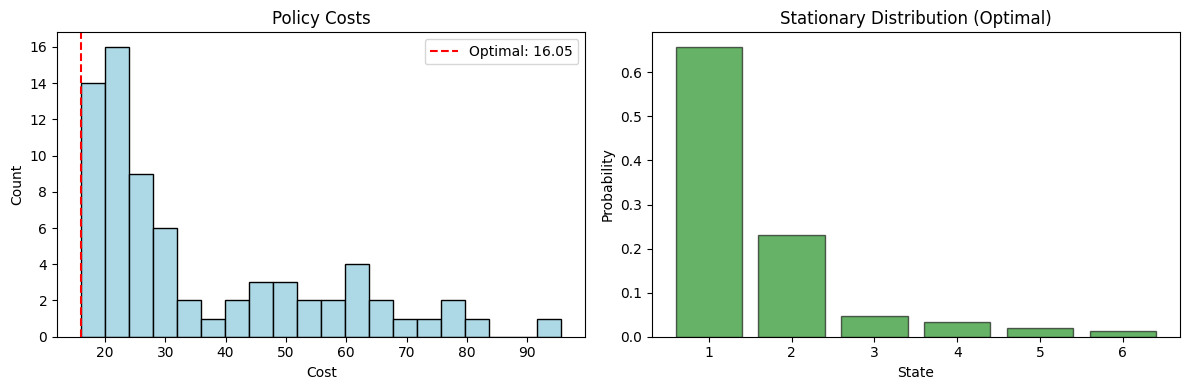

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Cost distribution
ax1.hist(results_df['Cost'], bins=20, color='lightblue', edgecolor='black')
ax1.axvline(optimal_cost, color='red', linestyle='--', label=f'Optimal: {optimal_cost:.2f}')
ax1.set_xlabel('Cost')
ax1.set_ylabel('Count')
ax1.set_title('Policy Costs')
ax1.legend()

# Stationary distribution
ax2.bar(range(1, 7), pi_opt, color='green', alpha=0.6, edgecolor='black')
ax2.set_xlabel('State')
ax2.set_ylabel('Probability')
ax2.set_title('Stationary Distribution (Optimal)')
ax2.set_xticks(range(1, 7))

plt.tight_layout()
plt.show()

## Summary

In [11]:
print(f"Total policies evaluated: {len(all_policies)}")
print(f"Optimal policy: {optimal_policy}")
print(f"Minimum cost: {optimal_cost:.4f}")
print(f"Maximum cost: {results_df['Cost'].max():.4f}")
print(f"Average cost: {results_df['Cost'].mean():.4f}")

Total policies evaluated: 72
Optimal policy: ('N', 'M', 'M', 'C', 'C', 'C')
Minimum cost: 16.0526
Maximum cost: 95.6634
Average cost: 35.6680
